# 8. Create a short complete analysis

Until now we have only seen pieces of code to do some specific segmentation of images. Typically however, one is going to have a complete analysis, including image processing and some further data analysis.

Here we are going to come back to an earlier dataset where *nuclei* appeared as circles. That dataset was a time-lapse, and we might be interested in knowing how those *nuclei* move over time. So we will have to analyze images at every time-point, find the position of the *nuclei*, track them and measure the distance traveled.

In [1]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
plt.gray();

import skimage.io

#import your function
from course_functions import detect_nuclei, random_cmap
cmap = random_cmap()

<Figure size 432x288 with 0 Axes>

## 8.1 Remembering previous work

Let's remember what we did in previous chapters. We opened the tif dataset, selected a specific plane to look at and segmented the *nuclei*. We use here again the AICS reader as we will need to access specific time points instead of loading the entire dataset (see [03-Image_import.ipynb](03-Image_import.ipynb) for details).

In [2]:
from aicsimageio import AICSImage
img = AICSImage("../Data/30567/30567.tif")

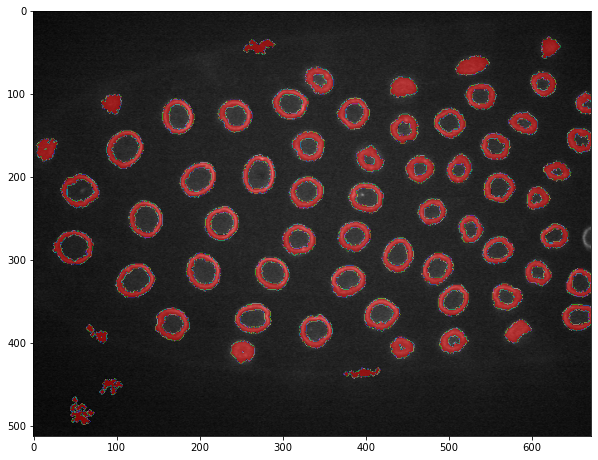

In [3]:
# load the image to process
image = img.get_image_data("YX", C=0, T=0, Z=3) 

# create your mask
nuclei = detect_nuclei(image)

#plot
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
plt.imshow(nuclei, cmap = cmap)
plt.show()

## 8.2 Processing a time-lapse

Thanks to the metadata we also remember the number of time-points and z-stacks that are available:

In [4]:
img.shape

(1, 72, 2, 5, 512, 672)

In [5]:
img.dims

'STCZYX'

72 time points, 2 colors, 5 planes per color.

The *nuclei* are going to move a bit in Z (perpendicular to the image) over time, so it will be more accurate to segment a projection of the entire stack. Again we will use the AICS importer to load a complete stack and project it:

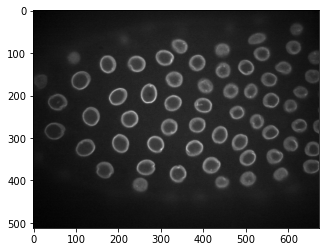

In [6]:
image_stack = img.get_image_data('ZYX', C=0, T=0)

plt.imshow(np.mean(image_stack, axis = 0));

Now we can 1. import each time point, 2. project the stack, 3. segment the image using our previously developed routine, 4. use region properties on the segmented image to locate all objects. Let's try with a single time-point first:

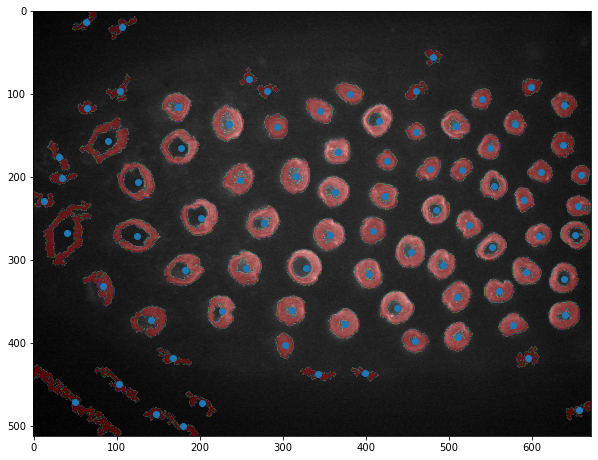

In [7]:
#choose a time
time = 10

#load the stack and segment it
image_stack = img.get_image_data('ZYX', C=0, T=time)
image = np.max(image_stack, axis = 0)
nuclei = detect_nuclei(image)

#find position of nuclei
nuclei_label = skimage.morphology.label(nuclei)
regions = skimage.measure.regionprops(nuclei_label)
centroids = np.array([x.centroid for x in regions])

#plto the result
plt.figure(figsize=(10,10))
plt.imshow(image, cmap = 'gray')
plt.imshow(nuclei, cmap = cmap,vmin = 0,vmax = 1,alpha = 0.6)
plt.plot(centroids[:,1], centroids[:,0],'o');

So now we can repeat the same operation for multiple time points and create a list of detected coordinates:

In [8]:
centroids_time = []
for time in range(10):

    #load the stack and segment it
    image_stack = img.get_image_data('ZYX', C=0, T=time)
    image = np.max(image_stack, axis = 0)
    nuclei = nuclei = detect_nuclei(image)

    #find position of nuclei
    nuclei_label = skimage.morphology.label(nuclei)
    regions = skimage.measure.regionprops(nuclei_label)
    centroids = np.array([x.centroid for x in regions])
    
    centroids_time.append(centroids)

Let's plot all those centroids for all time points

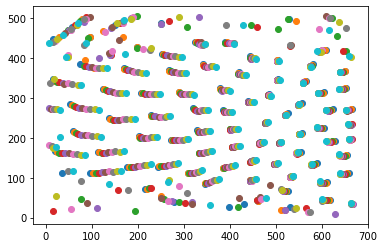

In [9]:
for x in centroids_time:
    plt.plot(x[:,1],x[:,0],'o')

We definitely see tracks corresponding to single nuclei here. How are we going to track them?

## 8.3 Tracking trajectories

One of the great strengths of Python is the very large amount of available packages for all sorts of tasks. For example, if we Google "python tracking", one of the first hits if for the package [trackpy](http://soft-matter.github.io/trackpy/v0.4.2/) which is originally designed to track particle diffusion but can be repurposed for other uses.

Browsing through the documentation and following a quick [walkthrough](http://soft-matter.github.io/trackpy/v0.4.2/tutorial/walkthrough.html), we see that we need the function ```link()``` to perform tracking. That function takes a dataframe as input. A Dataframe is a tabular format implemented by the package Pandas. We are not going into details here, but know that just like Numpy is a foundation of numerical computing, Pandas is a foundation of data science in the Python ecosystem. Here, just think of a Dataframe as a 2D numpy array where each column and row has in addition a label.

In [10]:
import trackpy
import pandas as pd

Let's look at the help for the link function:

In [11]:
help(trackpy.link)

Help on function link in module trackpy.linking.linking:

link(f, search_range, pos_columns=None, t_column='frame', **kwargs)
    link(f, search_range, pos_columns=None, t_column='frame', memory=0,
        predictor=None, adaptive_stop=None, adaptive_step=0.95,
        neighbor_strategy=None, link_strategy=None, dist_func=None,
        to_eucl=None)
    
    Link a DataFrame of coordinates into trajectories.
    
    Parameters
    ----------
    f : DataFrame
        The DataFrame must include any number of column(s) for position and a
        column of frame numbers. By default, 'x' and 'y' are expected for
        position, and 'frame' is expected for frame number. See below for
        options to use custom column names.
    search_range : float or tuple
        the maximum distance features can move between frames,
        optionally per dimension
    pos_columns : list of str, optional
        Default is ['y', 'x'], or ['z', 'y', 'x'] when 'z' is present in f
    t_column : str, 

We see that we have a lot of options, but initially we only have two obligatory parameters: a dataframe ```f``` with columns for x,y and time (frame) and a ```search_range``` defining how distant particles can be in a trajectory.

### 8.3.1 The position dataframe

There are different ways to create a Pandas dataframe. One of the simplest is just to transform a 2D Numpy array and assign names to the columns. Let's try with a single time-point. We had aggregated our detected positions in the list ```centroids_time```. Let's look at the first ten rows of time==0:

In [12]:
time = 0
centroids_time[time][0:10,:]

array([[ 26.14344262, 531.0204918 ],
       [ 25.73717949, 397.06410256],
       [ 33.00995025, 430.77114428],
       [ 45.24199744, 618.76952625],
       [ 38.62897527, 277.79858657],
       [ 41.55149502, 461.40199336],
       [ 67.4502924 , 526.33216374],
       [ 70.85933504, 215.23017903],
       [ 85.00906002, 345.05775764],
       [ 88.01252847, 611.27220957]])

So we see above the x and y positions, and we need to add a column for time (in this case time == 0). We can just concatenate the above array with a column filled with zeros. We can do that explicitly:

In [13]:
# create time column
time_column = time * np.ones((centroids_time[time].shape[0],1))

# concatenate with positions array
pos_time = np.concatenate([centroids_time[time], time_column],axis = 1)

We can do that of course for all arrays of the ```centroids_time``` list for example with a comprehension list:

In [14]:
centroids_time_conc = [np.concatenate([x, time * np.ones((x.shape[0],1))],axis = 1)
                       for time, x in enumerate(centroids_time)]
centroids_time_conc[6][0:10,:]

array([[ 12.82488479, 570.44239631,   6.        ],
       [ 20.97683398,  54.91505792,   6.        ],
       [ 33.48083624, 665.27526132,   6.        ],
       [ 43.25378788, 599.31060606,   6.        ],
       [ 40.94711538, 265.66826923,   6.        ],
       [ 45.43109541, 467.24381625,   6.        ],
       [ 77.88834951, 290.18446602,   6.        ],
       [ 86.15458937, 595.60225443,   6.        ],
       [ 91.04698972, 360.33773862,   6.        ],
       [ 92.40765766, 448.23648649,   6.        ]])

Now we have a list of Nx3 dimensional arrays whose columns represent x,y,frame. We can now concatenate all these arrays into one large array whose columns are still x,y,frame:

In [15]:
centroids_complete = np.concatenate(centroids_time_conc)

Finally we need to transform this Numpy array into a Pandas dataframe acceptable for trackpy. As mentioned before we can simply turn a Numpy array into a Dataframe by calling:

In [16]:
pd.DataFrame(centroids_complete)

,0,1,2
0,26.143443,531.020492,0.0
1,25.737179,397.064103,0.0
2,33.009950,430.771144,0.0
3,45.241997,618.769526,0.0
4,38.628975,277.798587,0.0
...,...,...,...
821,459.398400,36.171200,9.0
822,469.911894,615.828194,9.0
823,487.734072,70.443213,9.0
824,482.617925,428.589623,9.0


We see that the output is nicely formatted as a table. We also have bold numbers as columns and rows labels. Remember now that we need the specific labels x,y,frame fro trackpy. There are many options, when creating a Dataframe, one of them being to give a name to columns like this:

In [17]:
coords_dataframe = pd.DataFrame(centroids_complete, columns=('x','y','frame'))
coords_dataframe

,x,y,frame
0,26.143443,531.020492,0.0
1,25.737179,397.064103,0.0
2,33.009950,430.771144,0.0
3,45.241997,618.769526,0.0
4,38.628975,277.798587,0.0
...,...,...,...
821,459.398400,36.171200,9.0
822,469.911894,615.828194,9.0
823,487.734072,70.443213,9.0
824,482.617925,428.589623,9.0


That's it! We now have an appropriately formated dataframe to pass to our ```link``` function. Just a few more words about Pandas dataframes: they work very similarly to other Python objects. For example to recover a specific column we can use a dictionary-like syntax:

In [18]:
coords_dataframe['frame']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
821    9.0
822    9.0
823    9.0
824    9.0
825    9.0
Name: frame, Length: 826, dtype: float64

The object above is only one-dimensional and called a Pandas Series. Like with Numpy arrays, we can create boolean Series by doing comparisons e.g.:

In [19]:
coords_dataframe['frame'] == 9

0      False
1      False
2      False
3      False
4      False
       ...  
821     True
822     True
823     True
824     True
825     True
Name: frame, Length: 826, dtype: bool

Finally, we can use Numpy functions on Pandas objects. For example to get a maximum value of a column:

In [20]:
np.max(coords_dataframe['x'])

505.2455357142857

### 8.3.2 Tracking

As mentioned before, the only additional information we need for tracking is the allowed distance between linked objects between frames. This has to be adjusted to every case, here we chose 20px. And we can finally do the tracking:

In [21]:
tracks = trackpy.link(coords_dataframe, search_range=20)

Frame 9: 85 trajectories present.


In [22]:
tracks.head()

,x,y,frame,particle
0,26.143443,531.020492,0,0
57,346.670644,503.739857,0,1
56,343.934530,566.354805,0,2
55,325.821173,653.556509,0,3
54,325.070729,378.676823,0,4


The output is a new dataframe again with columns *x,y,frame* as well as an additional one called *particle*. Each row represents one object found at position *x*,*y* and time *frame*. The new column *particle* is an index that tells us to which track each particle belongs. Let's try to recover one track. For that we are using indexing. It works the same way as for a Numpy array: we create a boolean Series with a comparison (in Numpy e.g. ```myarray > threshold```) and then use it to index the same Dataframe (in Numpy e.g. ```myarray[myarray > threshold]```. For example we want to recover track number 1:
- first we create the boolean Series:

In [23]:
tracks['particle'] == 1

0      False
57      True
56     False
55     False
54     False
       ...  
765    False
764    False
763    False
771    False
825    False
Name: particle, Length: 826, dtype: bool

and then use it for indexing:

In [24]:
tracks[tracks['particle']==1]

,x,y,frame,particle
57,346.670644,503.739857,0,1
133,344.483504,503.163823,1,1
213,344.245614,502.598830,2,1
300,344.212953,502.046103,3,1
383,344.487459,502.248637,4,1
466,344.825619,502.121636,5,1
547,344.934985,502.660475,6,1
634,344.680736,504.689394,7,1
718,344.807407,506.412698,8,1
802,344.677005,508.314439,9,1


The dataframe above represent the complete track #1. We can do that for all tracks and plot the *x,y* positions for each track:

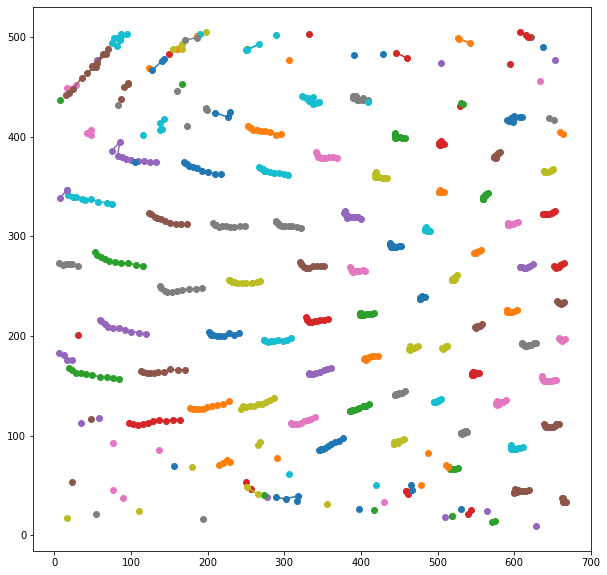

In [25]:
plt.figure(figsize=(10,10))
for particle_id in range(tracks['particle'].max()):
    plt.plot(tracks[tracks.particle==particle_id].y,
             tracks[tracks.particle==particle_id].x,'o-')
plt.show()

We see that most tracks seem reasonable. We had some remaining false positive objects that appear intermittently and whose tracks are of course shorter. We can further use trackpy to clean-up our result, for example by removing short tracks:

In [26]:
clean_tracks = trackpy.filter_stubs(tracks,threshold=9)

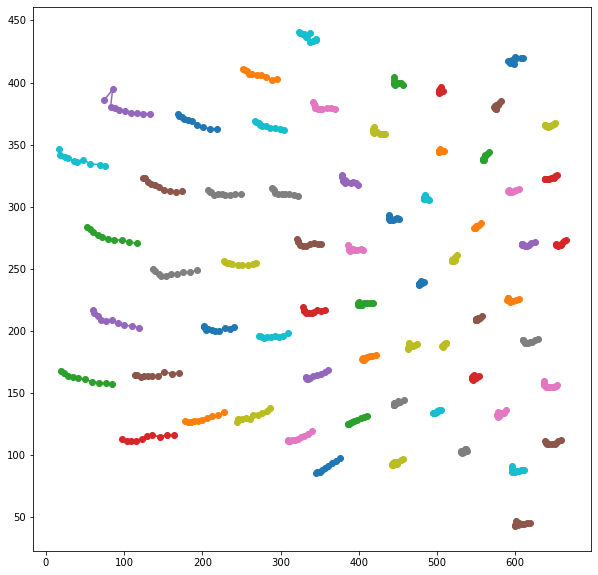

In [27]:
plt.figure(figsize=(10,10))
for particle_id in range(tracks['particle'].max()):
    plt.plot(clean_tracks[clean_tracks.particle==particle_id].y,
             clean_tracks[clean_tracks.particle==particle_id].x,'o-')
plt.show()

The visual impression is that we have a gradient in the magnitude of displacements. Let's see if we can quantify this effect.

## 8.4 Analysing the data

Such a data analysis would be easily done with the tracks Dataframe. However, since this course does not cover Pandas in details, we will transform the Dataframe into a Numpy array and do the analysis on the latter:

In [28]:
tracks_np = np.array(clean_tracks)
tracks_np

array([[346.67064439, 503.7398568 ,   0.        ,   1.        ],
       [343.9345301 , 566.35480465,   0.        ,   2.        ],
       [325.8211731 , 653.5565093 ,   0.        ,   3.        ],
       ...,
       [164.21812596, 547.77419355,   9.        ,  73.        ],
       [159.70674487, 636.26686217,   9.        ,  76.        ],
       [192.7893864 , 609.79933665,   9.        ,  67.        ]])

Now that we are back to a regular array, we know for example how to extract all particles from a given trajectory. Trajectory IDs are in the 4th columns so e.g. the ID #1 is:

In [29]:
track1 = tracks_np[tracks_np[:,3] == 1]
track1

array([[346.67064439, 503.7398568 ,   0.        ,   1.        ],
       [344.48350398, 503.16382253,   1.        ,   1.        ],
       [344.24561404, 502.59883041,   2.        ,   1.        ],
       [344.2129528 , 502.04610318,   3.        ,   1.        ],
       [344.48745911, 502.24863686,   4.        ,   1.        ],
       [344.82561895, 502.12163617,   5.        ,   1.        ],
       [344.93498452, 502.66047472,   6.        ,   1.        ],
       [344.68073593, 504.68939394,   7.        ,   1.        ],
       [344.80740741, 506.41269841,   8.        ,   1.        ],
       [344.67700535, 508.3144385 ,   9.        ,   1.        ]])

We now want to measure the total displacement from time=0 to time=9. For that we recover the first and last time point *x,y* coordinates. We use here a complex indexing where we have a list of indices ```[0,-1]``` for the rows:

In [30]:
track1[[0,-1],0:2]

array([[346.67064439, 503.7398568 ],
       [344.67700535, 508.3144385 ]])

Then we subtract the first row (first time-point) from the second (last time-point):

In [31]:
np.diff(track1[[0,-1],0:2], axis = 0)

array([[-1.99363904,  4.5745817 ]])

Finally we measure the length of this distance vector:

In [32]:
np.linalg.norm(np.diff(track1[[0,-1],0:2], axis = 0))

4.990129695107248

We can now execute this operation for all possible track IDs within a for loop and append the values to a list:

In [33]:
max_dist = []
for x in np.unique(tracks_np[:,3]):
    track1 = tracks_np[tracks_np[:,3] == x]
    dist = np.linalg.norm(np.diff(track1[[0,-1],0:2], axis = 0))
    max_dist.append(dist)
max_dist = np.array(max_dist)

In [34]:
max_dist

array([ 4.9901297 ,  9.39836346, 16.04142125, 22.13495449, 51.19551387,
       12.74595734, 34.20430138, 15.83868825,  6.83772258, 13.63823418,
        7.02945509, 64.75082456, 13.1320645 , 16.77767862, 31.85533137,
       20.02800901, 42.46774927,  4.98587814, 38.51326214, 50.31103373,
       12.64394062, 22.72713416, 20.09672431, 44.22474353, 13.77460325,
        4.22326945, 58.96826127,  8.7774507 , 28.82463296, 41.54881616,
       60.77586416,  3.74180177, 50.93647532, 26.06797193, 66.97242295,
       19.52712233, 31.68035881,  1.88327177, 12.31768856, 15.24019642,
       33.46554235, 18.19011827, 55.81962995, 44.69391663,  5.34139818,
       14.13421122, 17.90902175, 28.28111852, 61.25958887,  5.45349551,
       10.91247156, 19.04156436,  0.24151418, 36.36853026, 38.9337851 ,
       17.26466252, 65.69478123,  5.90408713, 28.71247264, 56.41969931,
       18.05404988, 11.17670013, 10.07220959])

Naturally we could also combine all these steps, including the for loop into a single comprehension list. Knowing each step above, you should be able to understand this:

In [35]:
max_distances = np.array([np.linalg.norm(np.diff(tracks_np[tracks_np[:,3] == x][[0,-1],0:2], axis = 0)) 
 for x in np.unique(tracks_np[:,3])])
max_distances

array([ 4.9901297 ,  9.39836346, 16.04142125, 22.13495449, 51.19551387,
       12.74595734, 34.20430138, 15.83868825,  6.83772258, 13.63823418,
        7.02945509, 64.75082456, 13.1320645 , 16.77767862, 31.85533137,
       20.02800901, 42.46774927,  4.98587814, 38.51326214, 50.31103373,
       12.64394062, 22.72713416, 20.09672431, 44.22474353, 13.77460325,
        4.22326945, 58.96826127,  8.7774507 , 28.82463296, 41.54881616,
       60.77586416,  3.74180177, 50.93647532, 26.06797193, 66.97242295,
       19.52712233, 31.68035881,  1.88327177, 12.31768856, 15.24019642,
       33.46554235, 18.19011827, 55.81962995, 44.69391663,  5.34139818,
       14.13421122, 17.90902175, 28.28111852, 61.25958887,  5.45349551,
       10.91247156, 19.04156436,  0.24151418, 36.36853026, 38.9337851 ,
       17.26466252, 65.69478123,  5.90408713, 28.71247264, 56.41969931,
       18.05404988, 11.17670013, 10.07220959])

Note that while this expression holds into a single line, it is harder to understand than the for loop. One should always find the right balance between conciseness and readability, but it is often a question of taste.

To know whether we indeed have a gradient along the horizontal axis, we need now to measure the average position of each track. So for each track ID, we recover the position *y* (index 1) for all frames and calculate the mean:

In [36]:
mean_pos = np.array([np.mean(tracks_np[tracks_np[:,3] == x,1]) for x in np.unique(tracks_np[:,3])])
mean_pos

array([503.79958915, 560.81934816, 643.99187222, 386.57839007,
       144.92404103, 595.49644545, 301.60993945, 423.14013969,
       485.19666493, 442.87596229, 550.44314337,  79.17696871,
       656.95207354, 613.53939036, 333.01975098, 392.93821487,
       224.1174717 , 521.10747788, 282.1415413 , 187.75149618,
       643.08315214, 334.82523036, 599.25623945, 269.7675609 ,
       448.19250005, 503.81948372, 100.61657744, 576.20624776,
       351.45695413, 244.61004846,  41.09250945, 478.54201916,
       199.18283973, 395.10150896, 127.44068117, 646.5158225 ,
       321.8283701 , 533.45692796, 447.02798845, 600.70517931,
       357.26528134, 606.51585627, 160.15367951, 263.77193642,
       498.57695226, 594.51776273, 405.36067916, 339.46366422,
        83.98748327, 551.66813022, 580.24595564, 616.94525153,
       509.00950413, 287.37451117, 217.05479597, 409.93062609,
        48.48672141, 547.33619097, 342.85706086, 136.59075351,
       643.55571111, 448.14455242, 466.42071367])

Now that we have the average *y* position of each track and the displacement between first and last point, we can plot this:

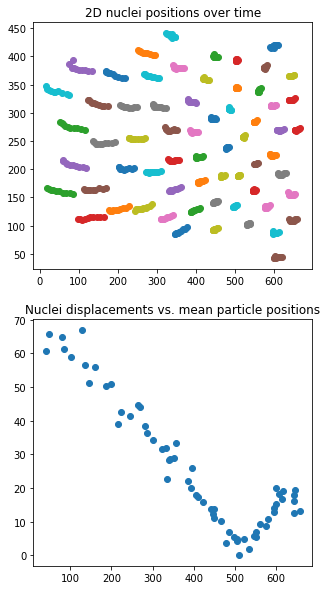

In [37]:
fig,ax = plt.subplots(2,1, figsize=(5,10))
for particle_id in range(tracks['particle'].max()):
    ax[0].plot(clean_tracks[clean_tracks.particle==particle_id].y,
             clean_tracks[clean_tracks.particle==particle_id].x,'o-')
ax[0].set_title('2D nuclei positions over time')
ax[1].plot(mean_pos, max_dist,'o')
ax[1].set_title('Nuclei displacements vs. mean particle positions');

And yes, we managed to clearly show that there is a gradient of displacement along the horizonal axis. So in summary we went from image import, to image segmentation, data extraction, and data analysis all in one notebook!